# Function Calling

In questo esercizio faremo fine-tuning del modello SmolLM2-135-Instruct su un task molto specifico (e molto utile): function calling.

In cosa consiste? Sostanzialmente stiamo insegnando a un modello linguistico, data una serie di funzioni con relativi parametri e una richiesta di un utente, a selezionare la funzione più opportuna da invocare.

Un esempio? Pensate ad Alexa. Dico "Accendi la luce", e Alexa invoca la funzione per accendere la luce.

Come dataset usiamo "glaiveai/glaive-function-calling-v2".

Come tecnica di fine tuning, **in questo caso usiamo LoRA**.


Prima di tutto installiamo tutti i pacchetti di cui abbiamo bisogno:

In [ ]:
!pip install huggingface-hub numpy torch trl

In [ ]:
!pip install -U datasets fsspec bitsandbytes

## **Download del Modello**

Prima di tutto però carichiamo il modello base.
In questo caso usiamo `SmolLM2-135M-Instruct`, che è la versione addestrata sulle chat del modello grezzo `SmolLM2-135M`.

Questo modello se la cava decentemente a rispondere a gestire conversazioni semplici, come rispondere a delle domande degli utenti, ma non è stato addestrato su nessun task specifico.

In [ ]:
# Importiamo le dipendenze
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

# Definiamo il dispositivo su cui eseguire il modello in base alla disponibilità.
# CUDA (GPU), MPS (Apple Silicon) o CPU.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

# Carichiamo il modello SmolLM2-135-Instruct
model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"

# Scarichiamo il modello
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
)

# Scarichiamo il relativo tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

Abbiamo caricato il modello!
Ora creiamo una funzione di utility per poterlo eseguire comodamente:

In [ ]:
# Definiamo una funzione che genera una risposta dal modello.
def generate_response(model, tokenizer, prompt, system_prompt=None):
    # Preparo il prompt in modalità chat e lo formatto in modo che il modello possa leggerlo.
    messages = [{"role": "user", "content": prompt}]
    # Se è presente un system prompt, lo aggiungo alla lista dei messaggi.
    if system_prompt:
        messages.insert(0, {"role": "system", "content": system_prompt})
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)
    # Tokenizzo il prompt
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
    # Lo passo al modello e gli chiedo di generare una risposta.
    outputs = model.generate(**inputs, max_new_tokens=512)
    # Decodifico la risposta del modello.
    output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Stampo la risposta, prendendo l'ultima parte della risposta del modello.
    return output.split("assistant")[-1].strip()

E ora proviamolo su una domanda generalista:

In [ ]:
# Proviamo a chiedergli una domanda generale.
print(generate_response(model, tokenizer, "What's the capital of France?"))

Su questo tipo di task sembra cavarsela.

Noi però vogliamo insegnargli a gestire un task di tipo **function calling**. Cosa si intende?

Sostanzialmente vogliamo che, a partire da una lista di funzioni e una richiesta di un utente, sia in grado di selezionare la funzione corretta e scegliere i parametri idonei rispettando la struttura data.

## Test modello base
Per comodità, definiamo una funzione che, date le firme di funzioni in formato JSON Schema di alcune funzioni con i loro parametri (in json o come stringa), ritorni un system prompt che chieda al modello di eseguire il nostro task di function calling.

In [ ]:
import json

def system_prompt_from_functions(functions: list[str | dict]):
  fn = functions
  if any(isinstance(element, dict) for element in functions):
    fn = [json.dumps(fn, indent=0) for fn in functions]
  functions_as_string = '\n'.join(fn)
  base_prompt = 'You are a helpful assistant with access to the following functions. Use them if required - '
  return '\n'.join([base_prompt, functions_as_string])


Ora testiamo il modello base prima del finetuning. Come se la cava sul function calling?

In [ ]:
# Definiamo la firma di una funzione in formato JSON Schema
function = {
"name": "validate_fiscal_code",
"description": "Given a fiscal code, it returns true if it's valid, false otherwise",
"parameters": {
  "type": "object",
  "properties": {
    "fiscal_code": {
      "type": "string",
      "description": "The fiscal code to validate"
    }
  },
  "required": ["fiscal_code"]}
}

# E chiediamo al modello di generare una password di 10 caratteri.
print(generate_response(
        model,
        tokenizer,
        "Is CTTPLL98T10B123F a valid fiscal code?.",
        system_prompt=system_prompt_from_functions([function])
    ))

Come possiamo vedere, seppur il modello base è capace di rispondere correttamente alla domanda sulla capitale della Francia, non è in grado di invocare la funzione per validare un codice fiscale.

Ci saremmo aspettati un output simile l seguente:

`<functioncall> {"name": "validate_fiscal_code", "arguments": '{"fiscal_code": "CTTPLL98T10B123F"}'} <|endoftext|>`

Quello che vogliamo fare è quindi insegnare a questo modello come invocare una funzione, data la sua descrizione e i suoi parametri, così che possa poi essere utile in ambiti come la domotica o come assistente virtuale simile ad alexa!

## **Preparazione dei Dataset**

Per questo esercizio, useremo il dataset `glaiveai/glaive-function-calling-v2`.

Possiamo dargli un'occhiata da qui:
https://huggingface.co/datasets/glaiveai/glaive-function-calling-v2

Carichiamolo da Huggingface e mostriamo dei dati di esempio:

In [ ]:
# Importiamo le dipendeze per i dataset
import json, multiprocessing
from datasets import load_dataset

# Carichiamo il dataset dalla repository di hugging face.
dataset_path = "glaiveai/glaive-function-calling-v2"
dataset = load_dataset(dataset_path, num_proc=multiprocessing.cpu_count())

# Mostriamo degli esempi del dataset
print("Ecco un esempio:", json.dumps(dataset["train"][0], indent=4))
print("Eccone un altro:", json.dumps(dataset["train"][2], indent=4))

# Notare che dataset è un oggetto Dataset python contente solo la parte di training, quindi dovremo dividerlo.
print("Chiavi del dizionario:")
print(list(dataset.keys()))
print(dataset)

Questo dataset contiene anche alcune chat dove non viene utilizzata nessun tipo di funzione.
Perciò per il finetuning del modello andremo a filtrare solo le chat che contengono una function call oppure dove il modello non è in grado di assistere.

In [ ]:
# Imposto un seed con un valore fisso, in modo che ripetendo questo colab, il risultato sarà sempre uguale.
seed = 42

reduced_dataset = dataset['train'].filter(
        lambda x: "I'm sorry" in x["chat"] or "functioncall" in x["chat"]
    )
reduced_dataset = reduced_dataset.shuffle(seed)

Per un corretto allenamento dobbiamo stare attenti al numero di casi nel dataset in cui il modello non è in grado di rispondere.

Ovvero dobbiamo selezionare un numero di chat nel dataset in cui è presente una funzione che l'assistente non è in grado di svolgere, perchè non fornita nel system prompt (chat facilmente identificabili con `"I'm sorry"`), e un certo numero di chat in cui l'assistente è in grado di svolgere la richiesta fatta.

Il lavoro di preprocessing sui dataset è fondamentale per aumentare la qualità del training.

Garbage in -> garbage out.

In [ ]:
import random, re
from datasets import concatenate_datasets

# Definiamo il numero di samples del dataset che vogliamo prendere per le
# funzioni che riesce e non riesce ad identificare
missed_functions_amount, found_functions_amount = 100000, 100000
repeat_multiple_arguments_chats_pct = 0.75
found_functions_with_arguments = int(found_functions_amount * repeat_multiple_arguments_chats_pct)
n_total_samples = missed_functions_amount + found_functions_amount + found_functions_with_arguments

# Funzione che data una chat come stringa ritorna se ha più di un argomento
def has_more_than_one_argument(text):
    dict_arguments_str = re.search(r'"arguments"\s*:\s*({.*?})\s*(?=<\|endoftext\|>)', text, re.DOTALL)
    if dict_arguments_str:
        return dict_arguments_str.group(1)[:-1].count(":") > 1
    return False

# Dividiamo il dataset ottenuto prima in: function_found e function_missed
# Se "I'm sorry" è presente nella risposta la riga verrà considerata come "missed"
# Altrimenti come "found"
function_missed = reduced_dataset.filter(
  lambda x: "I'm sorry" in x["chat"] and not ("functioncall" in x["chat"])
)
function_found = reduced_dataset.filter(
  lambda x: "functioncall" in x["chat"]
)

function_with_arguments_found = function_found.filter(
    lambda x: has_more_than_one_argument(x["chat"].replace("'", ""))
)

# Ora tronchiamo il dataset in base ai parametri definiti in precedenza.
function_missed_truncated = function_missed.select(
  range(min(function_missed.num_rows, missed_functions_amount))
)
function_found_truncated = function_found.select(
  range(min(function_found.num_rows, found_functions_amount))
)
function_with_arguments_truncated = function_with_arguments_found.select(
  range(min(function_with_arguments_found.num_rows, found_functions_with_arguments))
)

# Concateniamo i due dataset ottenuti
concatenated_dataset = concatenate_datasets([
    function_missed_truncated,
    function_found_truncated,
    function_with_arguments_truncated
]).shuffle(seed)
print(f"Il Dataset contiene {concatenated_dataset.num_rows} righe.")

Ora dobbiamo applicare il formato corretto a tutto il dataset. Questo perché il modello di partenza è di tipo "Instruct", quindi è stato addestrato a rispondere in formato conversazionale (chat).

Per questo creiamo una funzione che sarà mappata su tutto il dataset

In [ ]:
import re

# Rimuoviamo possibili tag rimasti
def clear_message(msg_str):
    return msg_str.replace(" <|endoftext|>", "").strip()

# Funzione che trasforma una stringa di chat in una lista di dizionari con ruoli e contenuti
def parse_chat_to_dicts(chat_str):
    # Selezioniamo la stringa fino all'ultima "FUNCTION RESPONSE"
    # Così abbiamo più esempi per allenare il nostro modello
    matches = list(re.finditer(r"FUNCTION\sRESPONSE\:", chat_str))
    if matches:
        last_match = matches[-1]
        chat_until_last_function_call = chat_str[:last_match.start()].strip()
    else:
        chat_until_last_function_call = chat_str.strip()
    # Togliamo i caratteri ' che son lì per motivi di formattazione
    chat_until_last_function_call = chat_until_last_function_call.replace("'", '')
    # Ora dividiamo la stringa ottenuta in blocchi
    # Questi blocchi sono i messaggi di ciascun USER, ASSISTANT e FUNCTION RESPONSE
    blocks = re.split(r'\n{2,}', chat_until_last_function_call.strip())
    result = []
    skip_next_assistant = False

    for block in blocks:
        # Se questo è un ASSISTANT block e prima c'era un FUNCTION RESPONSE, lo saltiamo
        if skip_next_assistant:
            if block.startswith("ASSISTANT:"):
                skip_next_assistant = False
                continue
            else:
                skip_next_assistant = False

        # Se questo blocco è FUNCTION RESPONSE settiamo il flag per skippare il rpossimo ASSISTANT
        # e non parsiamo questo blocco.
        if block.startswith("FUNCTION RESPONSE:"):
            skip_next_assistant = True
            continue

        # Se arrivimo fino a qui aggiungiamo il blocco con il rispettivo ruolo alla coda dei messaggi
        if block.startswith("USER:"):
            role = "user"
            content = block.replace("USER:", "").strip()
        elif block.startswith("ASSISTANT:"):
            role = "assistant"
            content = block.replace("ASSISTANT:", "").strip()
        else:
            # Se non riconosciamo il ruolo lo skippiamo
            continue
        #print(content)
        #print(("-" if block != blocks[-1] else "#") * 100)
        # Aggiungiamo il messaggio alla coda
        result.append({"role": role, "content": clear_message(content)})

    return result

def tokenize_dataset(examples):
    chats = []
    for system_entry, chat_entry in zip(examples["system"], examples["chat"]):
        # Estraiamo il system prompt dopo "SYSTEM:"
        system_prompt = system_entry.split("SYSTEM:")[-1].strip()

        # Creiamo una lista di messaggi
        messages = [{"role": "system", "content": system_prompt}] + parse_chat_to_dicts(chat_entry)
        formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)
        chats.append(formatted_prompt)
    return tokenizer(chats, truncation=True, padding="max_length", max_length=512)

# Applichiamo il mapping al dataset
whole_dataset = concatenated_dataset.map(
  tokenize_dataset,
  batched=True,
  remove_columns=concatenated_dataset.column_names,
)


Ora dividiamo il dataset in `training` e `validation`

In [ ]:
# Fattore dei dati da utilizzare per la fase di evaluation e non per il training
train_eval_split = 0.02

# split between train and validation
train_eval_dataset = whole_dataset.train_test_split(test_size=train_eval_split)

print(f"Il Dataset diviso contiene "
      f"{train_eval_dataset['train'].num_rows} righe per il training e "
      f"{train_eval_dataset['test'].num_rows} righe per la validation."
)

print("Eccone un esempio:\n", train_eval_dataset['train'][1])


## **Addestramento del Modello**

Adesso manca la parte più importante, ovvero **addestrare** il nostro modello sui dati che abbiamo preparato!

Iniziamo a definire i paramentri di training e di LoRA.

**LoRA (Low-Rank-Adaptation)** è una tecnica **PEFT (Parameter-Efficient Fine-Tuning model)** che non va a modificare tutti parametri del modello, bensì ne aggiunge alcuni in più e ottimizza solo quelli, permettendo così al modello di adeguarsi al meglio al nuovo obbiettivo, senza dimenticare completamente i concetti imparati inizialmente.


In [ ]:
import os
from peft import get_peft_model, LoraConfig, PeftModel
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments


# LoRA Hyperparameters
lora_alpha = 64 # Più alto = più valore alle nuove cose apprese. Valore basso = più valore al training originale.
lora_r = 16 # Quanto è grande la matrice Lora. Più è grande, più apprende, ma più diventa pesante il training
lora_dropout = 0.12 # % di parametri da riazzerare. Serve a evitare overfitting.

# Training Parameters
num_train_epochs = 1
learning_rate = 5e-4 # quanto veloce è l'apprendimento. Valore alto = rapido ma instabile
gradient_checkpointing = True # Ottimizzazione per ridurre la (V)RAM consumata
tf32 = False
bf16=False
torch_compile = True # Ottimizzazione su torch

# Save params
name = f"SmolLM2-135M-Instruct-noqlora-r{lora_r}-alpha{lora_alpha}-BIG" # nome con cui salviamo il modello
output_dir = f"results/{name}"
if not os.path.exists('results'):
  os.mkdir('results')
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

# Lora Config
lora_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"], # su quali matrici applicare LORA. Queste 4 sono quelle del transformer
    init_lora_weights="gaussian", # Come inizializziamo la matrice? gaussian = gaussiana, zeros = tutto a zero
    task_type="CAUSAL_LM" # Standard per i modelli linguistici
)

# Carichiamo peft
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

# Definiamo i parametri per il training
training_args = SFTConfig(
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    gradient_checkpointing=gradient_checkpointing,
    bf16=bf16,
    tf32=tf32,
    torch_compile=torch_compile,
    dataloader_pin_memory=False,
    warmup_steps=50,
    max_steps=300,
    learning_rate=learning_rate,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    optim="adamw_torch",
    logging_strategy="steps",
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    save_steps=100,
    output_dir=output_dir,
    remove_unused_columns=True,
    seed=seed,
    report_to="none",

)


Come possiamo vedere i parametri addestrabili sono solo 1,843,200 rispetto ai 135M di parametri del modello totale.

Questo numero dipende da `lora_r`.

Ora possiamo creare il trainer e iniziare l'addrestramento!

In [ ]:
trainer = SFTTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_eval_dataset["train"],
    eval_dataset=train_eval_dataset["test"],
    peft_config=lora_config
)

print("Training...")
trainer.train()

In [ ]:
# Salviamo il risultato ottenuto in una cartella (sia modello che relativo tokenizer)
finetuned_model_path = f"{output_dir}/trained_model"
tokenizer.save_pretrained(finetuned_model_path)
peft_model.save_pretrained(finetuned_model_path)

#### Salvataggio del modello su Hugging Face Hub
Hugging Face Hub è una piattaforma cloud che funziona come repository centralizzato per modelli di machine learning, dataset e applicazioni AI. Lo utilizziamo per salvare e condividere il nostro adapter LoRA addestrato, rendendolo facilmente accessibile e riutilizzabile.
Il metodo push_to_hub() carica automaticamente il modello sul nostro account Hugging Face, dove potrà essere scaricato e utilizzato da altri o in progetti futuri.
#### Requisiti per il login:

Un account gratuito su huggingface.co
Un token di accesso (ottenibile da Settings → Access Tokens nel tuo profilo)
Inserire il token quando richiesto dal comando login()In alternativa possiamo anche utilizzare l'hub di Hugging Face, effettuando il login ed eseguire il push del modello

In [ ]:
from huggingface_hub import login
login()
peft_model.push_to_hub('monadestudio/smol-function-calling-lora-adapter', private=False)

### **Visualizzazione dell'addestramento**

Ora possiamo vedere in un grafico come è andato il nostro training!

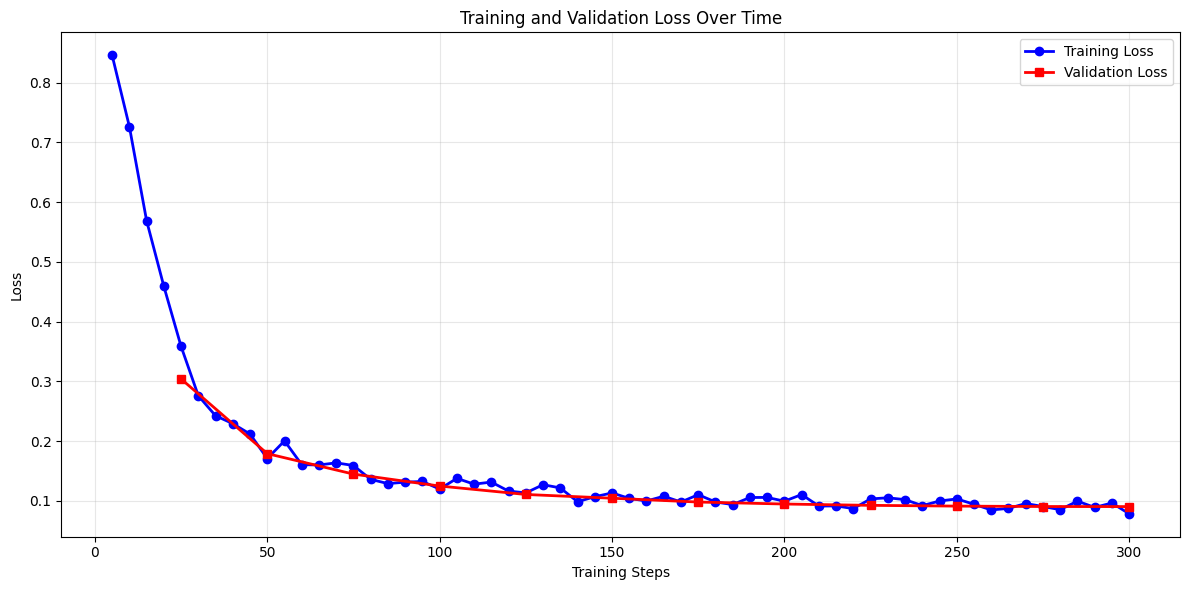

In [ ]:
import matplotlib.pyplot as plt

# Estrai i log dal trainer
log_history = trainer.state.log_history

# Separa training loss e validation loss
train_logs = [log for log in log_history if "loss" in log and "eval_loss" not in log]
eval_logs = [log for log in log_history if "eval_loss" in log]

# Estrai i valori
train_loss = [log["loss"] for log in train_logs]
eval_loss = [log["eval_loss"] for log in eval_logs]

# Crea gli step corrispondenti
train_steps = [log["step"] for log in train_logs]
eval_steps = [log["step"] for log in eval_logs]

# Crea il plot
plt.figure(figsize=(12, 6))
plt.plot(train_steps, train_loss, marker='o', label='Training Loss', color='blue', linewidth=2)
plt.plot(eval_steps, eval_loss, marker='s', label='Validation Loss', color='red', linewidth=2)

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

# Opzionale: stampa alcune statistiche
print(f"Training loss finale: {train_loss[-1]:.4f}")
print(f"Validation loss finale: {eval_loss[-1]:.4f}")
print(f"Numero di step di training: {len(train_steps)}")
print(f"Numero di step di validation: {len(eval_steps)}")

Come vediamo, il training loss tende a decrescere, quindi il modello ha appreso correttamente dagli esempi.

## **Prova Finale**

Infine riproviamo l'esempio fatto all'inizio e vediamo se riesce effettivamente a svolgere ciò che gli chiediamo.

Riproviamo a fargli generare una risposta sull'esempio provato all'inizio:

In [ ]:
# Funzioni per misurare la performnce
from time import perf_counter
from contextlib import contextmanager

# Funzione per calcolare il tempo di esecuzione
@contextmanager
def timer(name=""):
    start = perf_counter()
    yield
    end = perf_counter()
    print(f"[{name}] Elapsed: {end - start:.4f} sec")

In [ ]:
function = {
"name": "validate_fiscal_code",
"description": "Given a fiscal code, it returns true if it's valid, false otherwise",
"parameters": {
  "type": "object",
  "properties": {
    "fiscal_code": {
      "type": "string",
      "description": "The fiscal code to validate"
    }
  },
  "required": ["fiscal_code"]}
}

# E chiediamo al modello di generare una password di 10 caratteri.
print(generate_response(
        peft_model,
        tokenizer,
        "Is CTTPLL98T10B123F a valid fiscal code?.",
        system_prompt=system_prompt_from_functions([function])
    ))

### Salvataggio e distribuzione dei modelli

Ok, ora abbiamo addestrato il nostro modello. Come facciamo ad usarlo?

Un modo è semplicemente scaricarlo da colab come zip.

In [ ]:
import os
from google.colab import files

# Scommenta questo codice se vuoi scaricare il file come zip.
# os.system(f"zip -r {name}.zip {output_dir}")
# files.download(f"{name}.zip")

Un modo più elegante consiste nel condividerlo con i propri colleghi usando la repository di hugging face.

Prima di tutto accediamo con la nostra api key.

In [ ]:
from huggingface_hub import login
login()
your_user_name = ___INSERT_HERE_YOUR_HUGGING_FACE_USERNAME___


Ora ci basta invocare il metodo push_to_hub per caricarlo su una repository sul nostro profilo:

In [ ]:
peft_model.push_to_hub(f'{your_user_name}/smol-function-calling')
tokenizer.push_to_hub(f'{your_user_name}/smol-function-calling') # Ricordiamoci di mandare anche il tokenizer relativo

## Next steps
Inizialmente ci siamo detti che il punto forte di LoRA è che, non si va a modificare il modello originale, ma si aggiungono delle matrici per modificarne il comportamento.

Questo permette più semplicità di training e modularità della soluzione.

Tuttavia ci sono dei casi in cui ha senso unire il modello originale con il relativo Lora per ottenere un modello "unito", in modo da distribuirlo come standalone.

Ecco come fare:

In [ ]:
name = f"SmolLM2-135M-Instruct-noqlora-r16-alpha64-BIG" # nome con cui salviamo il modello
output_dir = f"results/{name}"

finetuned_model_path = f"{output_dir}/merged_model"

merged_model = peft_model.merge_and_unload()
merged_model.save_pretrained(finetuned_model_path)
#merged_model.push_to_hub(f'{your_user_name}/smol-function-calling')
#tokenizer.push_to_hub(f'{your_user_name}/smol-function-calling')

Testiamo il modello separato e unito: come noteremo, sono identici:

In [ ]:
function1 = {
    "name": "get_time",
    "description": "Get the current time at a given location",
    "parameters": {
        "type": "object",
        "properties": {
            "latitude": {
                "type": "number",
                "description": "The latitude of the location"
            },
            "longitude": {
                "type": "number",
                "description": "The longitude of the location"
            }
        },
        "required": [
            "latitude",
            "longitude"
        ]
    }
}

function2 = {
    "name": "get_weather",
    "description": "Get the weather at a given location",
    "parameters": {
        "type": "object",
        "properties": {
            "latitude": {
                "type": "number",
                "description": "The latitude of the location"
            },
            "longitude": {
                "type": "number",
                "description": "The longitude of the location"
            }
        },
        "required": [
            "latitude",
            "longitude"
        ]
    }
}

with timer(name="Generate Response for LoRA model"):
  test_prompts = [
    "What time is it in Tokyo (Lat: 35.6895, Long: 139.6917)?",
    "What's the weather like in New York (Lat: 40.7128, Long: -74.0060)?"
  ]
  for prompt in test_prompts:
    print(generate_response(
          peft_model,
          tokenizer,
          prompt,
          system_prompt=system_prompt_from_functions([function1, function2])
      ))

with timer(name="Generate Response for merged model"):
  test_prompts = [
    "What time is it in Tokyo (Lat: 35.6895, Long: 139.6917)?",
    "What's the weather like in New York (Lat: 40.7128, Long: -74.0060)?"
  ]
  for prompt in test_prompts:
    print(generate_response(
          merged_model,
          tokenizer,
          prompt,
          system_prompt=system_prompt_from_functions([function1, function2])
      ))


Questa sezione si conclude qui, prosegui con "03_convert_to_gguf.ipynb"